# Tutorial on collocating a dataset  with lagged data

#1) You will need to point the code to your input file.

#2) Ensure that your input file has the following Variables and Names:
    #Latitude = 'lat'
    #Longitude = 'lon'
    #Time = 'time'
    #Year = 'year'
    #Month = 'month'
    #Day = 'day'
    #Date = 'date'


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
import timeit
# filter some warning messages
warnings.filterwarnings("ignore") 
#from geopy.distance import geodesic 

####################you will need to change some paths here!#####################
#list of input files
#filename_bird='f:/data/project_data/NASA_biophysical/collocated_data/zoo_selgroups_HadSST_relabundance_5aug2019_plumchrusV_4regions_final.csv'
filename_bird='/Users/jeffdorman/Documents/python/data/allStationMetadata.csv'

#output files
filename_bird_out='~/Desktop/zoo_selgroups_HadSST_relabundance_5aug2019_plumchrusV_4regions_final_satsst.csv'
filename_bird_out_netcdf='~/Desktop/zoo_selgroups_HadSST_relabundance_5aug2019_plumchrusV_4regions_final_satsst.nc'
#################################################################################


/Users/jeffdorman/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jeffdorman/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Reading CSV datasets

In [2]:
#read in csv file in to panda dataframe & into xarray
df_bird = pd.read_csv(filename_bird)

df_bird

,Unnamed: 0,year,station,date,time,lat,lon,bottom_depth,tdr_depth,month,day
0,1,2011,110,5/13/11,12:00,36.5833,-122.1750,2304,34.0,5,13
1,3,2012,110,5/8/12,12:00,36.5833,-122.1750,2304,34.0,5,8
2,4,2011,112,5/13/11,12:00,36.6550,-121.9467,73,37.0,5,13
3,5,2012,112,5/8/12,12:00,36.6550,-121.9467,73,27.0,5,8
4,6,2011,114,5/12/11,12:00,36.7667,-121.8667,73,36.0,5,12
...,...,...,...,...,...,...,...,...,...,...,...
134,142,2017,493,5/11/17,12:00,35.0000,-120.8833,192,33.0,5,11
135,143,2015,495,6/10/15,12:00,35.0000,-121.1167,532,32.0,6,10
136,144,2016,495,5/13/16,12:00,35.0000,-121.1167,532,27.0,5,13
137,145,2017,495,5/12/17,12:00,35.0000,-121.1167,532,30.0,5,12


In [3]:
# calculate time, it needs a datetime64[ns] format
df_bird.insert(0,'Year',df_bird['year'])
df_bird.insert(1,'Month',df_bird['month'])
df_bird.insert(2,'Day',df_bird['day'])
df_bird=df_bird.drop(columns={'day','month','year'})
df_bird['time'] = df_bird['time'].apply(lambda x: x.zfill(8))
df_bird.insert(3,'Hour',df_bird['time'].apply(lambda x: x[:2]))
df_bird.insert(4,'Min',df_bird['time'].apply(lambda x: x[3:5]))
df_bird.insert(0,'time64',pd.to_datetime(df_bird[list(df_bird)[0:4]]))
df_bird=df_bird.drop(columns={'Day','Month','Year','Hour','Min','time','date'})

# transform to x array
ds_bird = df_bird.to_xarray()

In [ ]:
df_bird

<xarray.DataArray 'lat' ()>
array(32.7167) <xarray.DataArray 'lat' ()>
array(38.4667) <xarray.DataArray 'lon' ()>
array(-123.71) <xarray.DataArray 'lon' ()>
array(-117.5833)


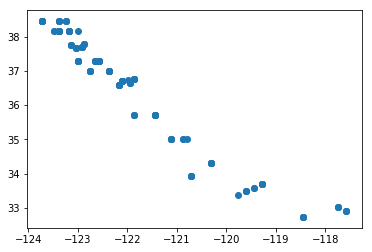

In [4]:
#just check lat/lon & see looks okay
minlat,maxlat=ds_bird.lat.min(),ds_bird.lat.max()
minlon,maxlon=ds_bird.lon.min(),ds_bird.lon.max()
plt.scatter(ds_bird.lon,ds_bird.lat)
print(minlat,maxlat,minlon,maxlon)

In [ ]:
#open cmc sst
ds = xr.open_zarr('F:/data/sat_data/sst/cmc/zarr').drop({'analysis_error','mask','sea_ice_fraction'})
ds

In [ ]:
#Resolution of the Satellite Data is 0.2 degrees.
#If you want to smooth the data, change smooth_lat and smooth lon to the number of 
#grid cells you want to include.  
#example: smooth_lat = 3 will compute a rolling average over 3 grid cells which equals 0.6 deg 
smooth_lat=1
smooth_lon=1
ds = ds.rolling(lat=smooth_lat,center=True,keep_attrs=True).mean(keep_attrs=True)
ds = ds.rolling(lon=smooth_lon,center=True,keep_attrs=True).mean(keep_attrs=True)
ds

In [ ]:
ds_mon = ds.rolling(time=30, center=False,keep_attrs=True).mean(keep_attrs=True)
ds_15 = ds.rolling(time=15, center=False,keep_attrs=True).mean(keep_attrs=True)
ds_week = ds.rolling(time=7, center=False,keep_attrs=True).mean(keep_attrs=True)
ds['analysed_sst_1mon']=ds_mon['analysed_sst']
ds['analysed_sst_15dy']=ds_15['analysed_sst']
ds['analysed_sst_1week']=ds_week['analysed_sst']
ds

# Collocate all data with bird data

In [ ]:
len(ds_bird.lat)


In [ ]:
ds_data = ds
for var in ds_data:
    var_tem=var
    ds_bird[var_tem]=xr.DataArray(np.empty(ilen_bird, dtype=str(ds_data[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
    ds_bird[var_tem].attrs=ds_data[var].attrs
print('var',var_tem)
for i in range(len(ds_bird.lat)):
#    for i in range(len(ds_bird.lat)):
#    if ds_bird.time[i]<ds_data.time.min():
#        continue
#    if ds_bird.time[i]>ds_data.time.max():
#        continue
    t1,t2 = ds_bird.time64[i]-np.timedelta64(24,'h'), ds_bird.time64[i]+np.timedelta64(24,'h')
    lat1,lat2=ds_bird.lat[i]-.5,ds_bird.lat[i]+.5
    lon1,lon2=ds_bird.lon[i]-.5,ds_bird.lon[i]+.5
    tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
    tem = tem.interp(time=ds_bird.time64[i],lat=ds_bird.lat[i],lon=ds_bird.lon[i])
    #tem = tem.load()
    for var in ds_data:
        var_tem=var
        ds_bird[var_tem][i]=tem[var].data
    if int(i/100)*100==i:
        print(i,len(ds_bird.lat))

#output data
df_bird = ds_bird.to_dataframe()
df_bird.to_csv(filename_bird_out)
#ds_bird.to_netcdf(filename_bird_out_netcdf)

In [ ]:
var2


In [ ]:
#test rolling to check
print(da.data)
da = xr.DataArray(np.linspace(0, 11, num=12),coords=[pd.date_range( "15/12/1999", periods=12, freq=pd.DateOffset(months=1), )],dims="time",)
dar = da.rolling(time=3,center=False).mean()  #before and up too
print(dar.data)